In [20]:
#Creators -
#Shreejit Gajanan Deshmukh
#Venkata Sai Advaith Kandiraju
#PRCV Spring 2023' Assignment 5 - Deep learning

In [21]:
#Summary -
#This program trains our neural network on the most popular MNIST digits dataset.
#The input is hand written digits from 0-9 with over 64000 examples, we train our 
#network on these digits and then try to find accuracy of our model using test set
#with 100000 examples

In [22]:
#importing libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
#defining neural networks parameters
#Reruns
n_epochs = 5

#batch sizes for train and test
batch_size_train = 64
batch_size_test = 1000

#Hyperparameters
learning_rate = 0.01
momentum = 0.5
log_interval = 10

#Network parameters for random initialization and using CPU
random_seed = 6
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [24]:
#Loading train data using torchvision dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

#Loading test data using torchvision dataset
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [25]:
#Testing the loaded data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_targets[0]

tensor(6)

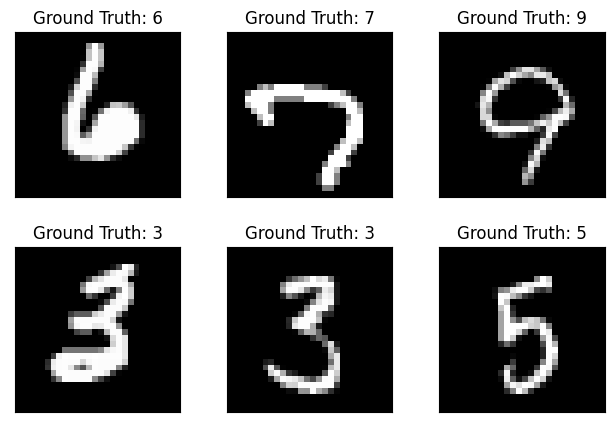

In [26]:
#Visualizing data
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [27]:
#Building the network with 2 convolution layers and following Relu, pooling and dropout layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    #Defining how we should feed forward our network
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [28]:
#Initializing our neural network with the class defined above and the optimizer using stochastic gradient descent
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [29]:
#Initializing trackers for later analysis of our training
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [30]:
#This function for each epoch performs forward feed and then calculates loss. Then the loss is back propagated to optimize
#the weights of the network. We are printing values for batches for better tracking the progress of our network.
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [31]:
#This function performs testing on the test set. It just compares our prediction for the hand drawn digit to the ground 
#truth, then it returns the correct prediction accuracy for the test set.
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [32]:
#Performing the train-test cycles for our predefined number of epochs.
#We perform test once before training to see the random matching of our prediction v/s ground truth for test set.
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\shree\AppData\Local\Temp\ipykernel_18612\740197875.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3178, Accuracy: 1040/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348719
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307755
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266718
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.254243
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.251411
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.199928
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.171053
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.116656
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056964
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.825694
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.596221
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.300503
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.312382
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.056972
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.058461
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.803205
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.972025
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.761083
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.927909
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.071649
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.241904
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.436602
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.107712
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.103730
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.169550
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.207310
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.126755
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.250298
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.261028
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.285686
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.196815
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.253967
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.266147
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.138697
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.105959
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.362554
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.102528
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.260738
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.108328


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.151684
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.086497
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.092200
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.082561
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.114063
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.259862
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.117133
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.087506
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.156975
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.089797
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.034388
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.098018
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.065037
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.170101
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.325862
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.205713
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.058609
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.066715
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.086670
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.164641


Text(0, 0.5, 'negative log likelihood loss')

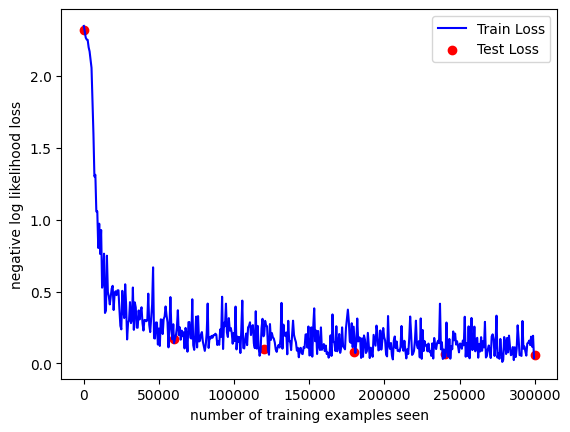

In [34]:
#Plotting the progress of our network. Log values of train loss in blue and log test loss in red.
fig = plt.figure()
plt.plot(train_counter, train_losses, color = 'blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')